In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from basics import *

%matplotlib inline

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

## Speech Translation - BLEU

BLEU scores with varying amount of training data used

In [55]:
# x_labels = ['20 hrs', '25 hrs', '40 hrs', '50 hrs', '80 hrs', '160 hrs\n(100%)']
x_labels = ['20', '25', '40', '50', '80', '160']
x_scale = np.array([12.5, 16.7, 25, 33, 50, 100])

bleu =           np.array([4.56, 8.36, 11.86, 15.47, 19.18, 27.04])

bleu_beam =      np.array([5.08, 9.37, 13.34, 17.11, 21.07, 29.53])

precision =      np.array([33.7, 39.8, 45.7,  51.2,  56.1,  63.5])
precision_beam = np.array([34,   41.7, 48.5,  53.3,  58.6,  66.6])

meteor =         np.array([12.8, 15.8, 18.5,  21.2,  23.1,  27.4])
meteor_beam =    np.array([12.6, 16.0, 18.7,  21.6,  23.7,  28.2])

recall =         np.array([28.6, 34.7, 39.8,  45.0,  48.3,  56.1])
recall_beam =    np.array([27.9, 34.7, 39.5,  45.4,  49.1,  56.9])
recall_exact=    np.array([23.7, 30.7, 35.4,  40.8,  44.8,  52.6])

precision_cnt =  np.array([13.7,   26.2, 36.3,  44.5,  51.2,  63.7])
recall_cnt =     np.array([12.6, 24.3, 33.5,  43.1,  50.6,  62.1])

google_cnt_prec = 76.9
google_cnt_recall = 78.1
google_exact_recall = 66.3
google_recall = 70.7

bar_x = np.linspace(5,100,6)

# bar_x = 

In [16]:
sns.set_style("whitegrid", {"axes.grid": True})

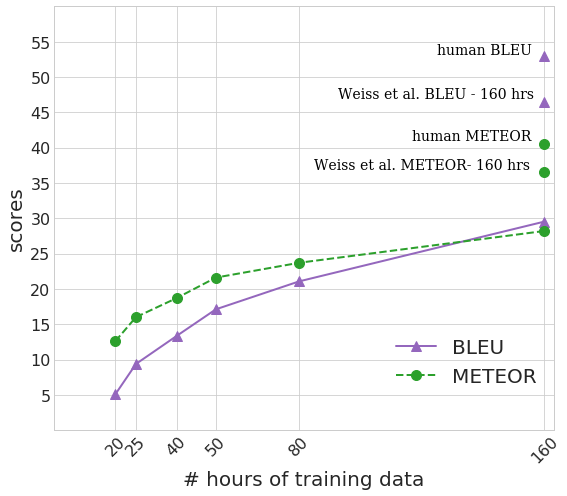

In [50]:
fig, ax = plt.subplots(figsize=(8,7),nrows=1, ncols=1, sharey=True)

markersize = 10
linewidth = 2
alpha = 1

ax.plot(x_scale, bleu_beam, label="BLEU", color=tableau20[8], 
        linewidth=linewidth, alpha=alpha, linestyle="-",
        marker='^', markersize=markersize)


ax.plot(x_scale, meteor_beam, label="METEOR", color=tableau20[4], 
        linewidth=linewidth, alpha=alpha, 
        marker='o', markersize=markersize, linestyle="--")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

ax.plot(np.array([100]), np.array([46.5]), color=tableau20[8],
        marker='^', markersize=markersize)
plt.text(58, 47, r'Weiss et al. BLEU - 160 hrs', fontdict=font)
ax.plot(np.array([100]), np.array([36.5]), color=tableau20[4],
        marker='o', markersize=markersize)
plt.text(53, 37, r'Weiss et al. METEOR- 160 hrs', fontdict=font)

ax.plot(np.array([100]), np.array([53]), color=tableau20[8],
        marker='^', markersize=markersize)
plt.text(78, 53.2, r'human BLEU', fontdict=font)
ax.plot(np.array([100]), np.array([40.5]), color=tableau20[4],
        marker='o', markersize=markersize)
plt.text(73, 41, r'human METEOR', fontdict=font)

# ax.axhline(y=46.5, linestyle=":")
# plt.text(40, 47, r'Weiss et al. BLEU - 160 hrs', fontdict=font)
# ax.axhline(y=36.5, linestyle=":")
# plt.text(40, 37, r'Weiss et al. METEOR- 160 hrs', fontdict=font)

# ax.axhline(y=53, linestyle="-.")
# plt.text(40, 53.5, r'Human BLEU', fontdict=font, alpha=0.5)
# ax.axhline(y=40.5, linestyle="-.")
# plt.text(40, 41, r'Human METEOR', fontdict=font, alpha=0.5)

plt.xticks(x_scale, x_labels, rotation=45, fontsize=16)
# plt.yticks(list(range(5,25,5))+[27, 47, 53, 37, 41], rotation=0, fontsize=20)
plt.yticks(list(range(5,60,5)), rotation=0, fontsize=20)
ax.set_xlabel('# hours of training data', size=20)
ax.set_ylabel('scores', size=20)
for i in ax.get_xticklabels():
    i.set_fontsize(16)
for i in ax.get_yticklabels():
    i.set_fontsize(16)

plt.legend(bbox_to_anchor=(1.0, 0.26), framealpha=0, fontsize=20, ncol=1)
plt.ylim(0,60)
plt.xlim(0,102)
# ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

fig.tight_layout()

fig.savefig(fname="bleu_meteor_scores.pdf", dpi=300)
fig.savefig(fname="bleu_meteor_scores.png", dpi=300)

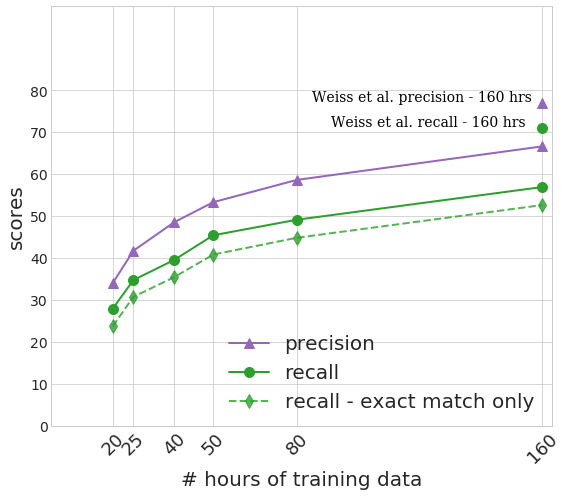

In [59]:
fig, ax = plt.subplots(figsize=(8,7),nrows=1, ncols=1, sharey=True)

markersize = 10
linewidth = 2
alpha = 1

ax.plot(x_scale, precision_beam, label="precision", color=tableau20[8], 
        linewidth=linewidth, alpha=alpha,
        marker='^', markersize=markersize)

ax.plot(x_scale, recall_beam, label="recall", color=tableau20[4], 
        linewidth=linewidth, alpha=alpha, 
        marker='o', markersize=markersize, linestyle="-")

ax.plot(x_scale, recall_exact, label="recall - exact match only", color=tableau20[4], 
        linewidth=linewidth, alpha=0.8, 
        marker='d', markersize=markersize, linestyle="--")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

ax.plot(np.array([100]), np.array([77]), color=tableau20[8],
        marker='^', markersize=markersize)
plt.text(53, 77.3, r'Weiss et al. precision - 160 hrs', fontdict=font)
ax.plot(np.array([100]), np.array([71]), color=tableau20[4],
        marker='o', markersize=markersize)
plt.text(57, 71.3, r'Weiss et al. recall - 160 hrs', fontdict=font)

# ax.axhline(y=77, linestyle=":")
# plt.text(40, 77.5, r'Weiss et al. precision - 160 hrs', fontdict=font)
# ax.axhline(y=71, linestyle=":")
# plt.text(40, 71.5, r'Weiss et al. recall - 160 hrs', fontdict=font)

# ax.axhline(y=81, linestyle="-.")
# plt.text(40, 81.5, r'Human precision - 160 hrs', fontdict=font)
# ax.axhline(y=76, linestyle="-.")
# plt.text(40, 76.5, r'Human recall - 160 hrs', fontdict=font)

plt.xticks(x_scale, x_labels, rotation=45, fontsize=16)
# plt.yticks(list(range(0,65,10))+[76, 71, ], rotation=0, fontsize=20)
plt.yticks(list(range(0,81,10)), rotation=0, fontsize=20)
ax.set_xlabel('# hours of training data', size=20)
ax.set_ylabel('scores', size=20)
for i in ax.get_xticklabels():
    i.set_fontsize(18)
for i in ax.get_yticklabels():
    i.set_fontsize(14)

plt.legend(bbox_to_anchor=(1.0, 0.26), framealpha=0, fontsize=20, ncol=1)
plt.ylim(0,100)
plt.xlim(0,102)
# ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

fig.tight_layout()

fig.savefig(fname="precision_recall_scores.pdf", dpi=300)
fig.savefig(fname="precision_recall_scores.png", dpi=300)

In [10]:
google_cnt_recall

78.1

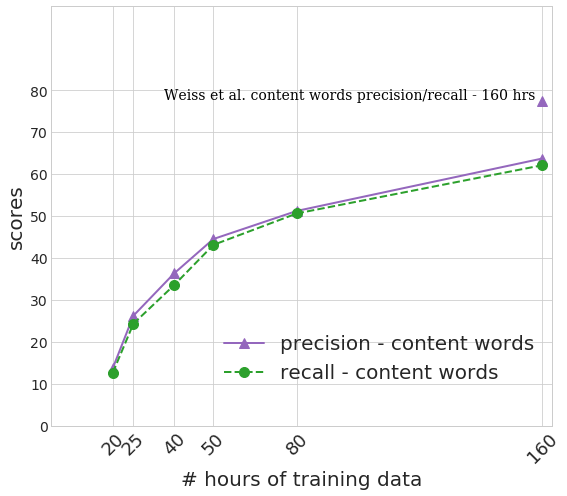

In [62]:
fig, ax = plt.subplots(figsize=(8,7),nrows=1, ncols=1, sharey=True)
# sns.set_style("white")
# sns.set_style("ticks")

# x_labels = ["{0:d} hrs".format(int(160 * (i/100))) for i in x_scale]

markersize = 10
linewidth = 2
alpha = 1

ax.plot(x_scale, precision_cnt, label="precision - content words", color=tableau20[8], 
        linewidth=linewidth, alpha=alpha,
        marker='^', markersize=markersize)

ax.plot(x_scale, recall_cnt, label="recall - content words", color=tableau20[4], 
        linewidth=linewidth, alpha=alpha, 
        marker='o', markersize=markersize, linestyle="--")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

ax.plot(np.array([100]), np.array([77.5]), color=tableau20[8],
        marker='^', markersize=markersize)
plt.text(23, 77.8, r'Weiss et al. content words precision/recall - 160 hrs', fontdict=font)

# ax.axhline(y=google_cnt_prec, linestyle=":")
# plt.text(30, google_cnt_prec+0.5, r'precision', fontdict=font)
# ax.axhline(y=77.5, linestyle=":")
# plt.text(20, 78, r'Weiss et al. content words precision-recall - 160 hrs', fontdict=font)

# ax.axhline(y=81, linestyle="-.")
# plt.text(40, 81.5, r'Human precision - 160 hrs', fontdict=font)
# ax.axhline(y=76, linestyle="-.")
# plt.text(40, 76.5, r'Human recall - 160 hrs', fontdict=font)

plt.xticks(x_scale, x_labels, rotation=45, fontsize=16)
# plt.yticks(list(range(0,65,10))+[76, 71, ], rotation=0, fontsize=20)
plt.yticks(list(range(0,81,10)), rotation=0, fontsize=20)
ax.set_xlabel('# hours of training data', size=20)
ax.set_ylabel('scores', size=20)
for i in ax.get_xticklabels():
    i.set_fontsize(18)
for i in ax.get_yticklabels():
    i.set_fontsize(14)

plt.legend(bbox_to_anchor=(1.0, 0.26), framealpha=0, fontsize=20, ncol=1)
plt.ylim(0,100)
plt.xlim(0,102)
# ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

fig.tight_layout()

fig.savefig(fname="precision_recall_content.pdf", dpi=300)
fig.savefig(fname="precision_recall_content.png", dpi=300)

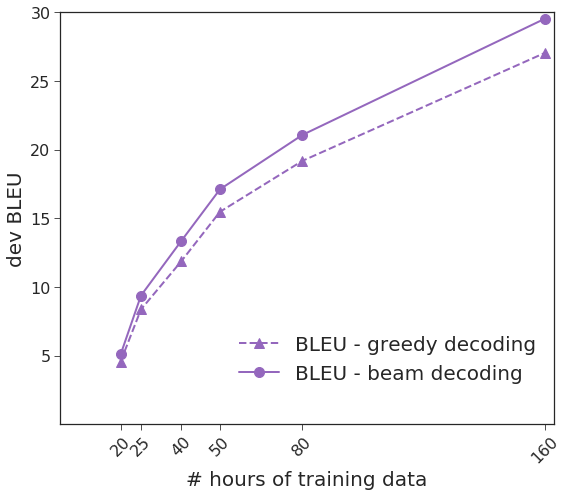

In [41]:
fig, ax = plt.subplots(figsize=(8,7),nrows=1, ncols=1, sharey=True)
sns.set_style("white")

# x_labels = ["{0:d} hrs".format(int(160 * (i/100))) for i in x_scale]

markersize = 10
linewidth = 2
alpha = 1

ax.plot(x_scale, bleu, label="BLEU - greedy decoding", color=tableau20[8], 
        linewidth=linewidth, alpha=alpha, linestyle="--",
        marker='^', markersize=markersize)

ax.plot(x_scale, bleu_beam, label="BLEU - beam decoding", color=tableau20[8], 
        linewidth=linewidth, alpha=alpha, linestyle="-",
        marker='o', markersize=markersize)

# ax.plot(x_scale, meteor, label="meteor", color=tableau20[5], 
#         linewidth=linewidth, alpha=alpha, 
#         marker='o', markersize=markersize, linestyle="--")

# ax.plot(x_scale, meteor, label="meteor - beam", color=tableau20[5], 
#         linewidth=linewidth, alpha=alpha, 
#         marker='o', markersize=markersize, linestyle="-")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

# ax.axhline(y=46.5, linestyle=":")
# plt.text(40, 47, r'Google bleu - 160 hrs', fontdict=font)
# ax.axhline(y=36.5, linestyle=":")
# plt.text(40, 37, r'Google meteor- 160 hrs', fontdict=font)

# ax.axhline(y=53, linestyle="-.")
# plt.text(40, 53.5, r'Human bleu - 160 hrs', fontdict=font, alpha=0.5)
# ax.axhline(y=40.5, linestyle="-.")
# plt.text(40, 41, r'Human meteor - 160 hrs', fontdict=font, alpha=0.5)

plt.xticks(x_scale, x_labels, rotation=45, fontsize=16)
# plt.yticks(list(range(5,25,5))+[27, 30], rotation=0, fontsize=20)
plt.yticks(list(range(5,31,5)), rotation=0, fontsize=20)
ax.set_xlabel('# hours of training data', size=20)
ax.set_ylabel('dev BLEU', size=20)
for i in ax.get_xticklabels():
    i.set_fontsize(16)
for i in ax.get_yticklabels():
    i.set_fontsize(16)

plt.legend(bbox_to_anchor=(1.0, 0.26), framealpha=0, fontsize=20, ncol=1)
plt.ylim(0,30)
plt.xlim(0,102)
ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

fig.tight_layout()

fig.savefig(fname="bleu_beam.pdf", dpi=300)
fig.savefig(fname="bleu_beam.png", dpi=300)

In [32]:
utt_len_x = ['25', '50', 'Weiss et al.']
bleu_short = np.array([14.03, 21.90, 33.94])
bleu_medium = np.array([11.09, 18.81, 47.42])
bleu_long = np.array([6.91, 13.21, 45.87])
width = 0.9
gap = 1

NameError: name 'ind' is not defined

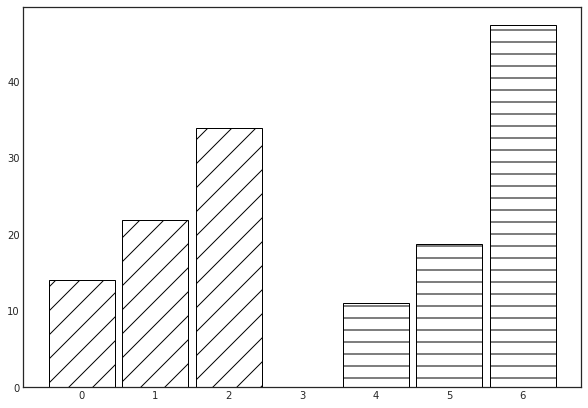

In [37]:
fig, ax = plt.subplots(figsize=(10,7),nrows=1, ncols=1, sharey=True)
sns.set_style("white")

ind_short = np.arange(len(utt_len_x))
ax.bar(ind_short, bleu_short, width=width, fill=False,
       color=tableau20[1], edgecolor='black', hatch="/", label="short utts")

ind_med = ind_short+len(ind_short)+gap
ax.bar(ind_med, bleu_medium, width=width, fill=False, 
       color=tableau20[1], edgecolor='black', hatch="-", label="medium utts")

ind_long = ind_med+len(ind)+gap
ax.bar(ind_long, bleu_long, width=width, fill=False, 
       color=tableau20[3], edgecolor='black', hatch="x", label="long utts")


all_inds = np.array(ind_short.tolist() + ind_med.tolist() + ind_long.tolist())
all_x_ticks = utt_len_x * 3

plt.xticks(all_inds, all_x_ticks, rotation=45, fontsize=18)


# ax.axhline(y=50, linestyle="--", color="black")
# plt.text(2.5, 53.5, r'Human bleu - 160 hrs', fontdict=font, alpha=0.9)
ax.axhline(y=50, color='black', linestyle="--")

# plt.yticks(list(range(5,30,5))+[34, 50], rotation=0, fontsize=20)
plt.yticks(list(range(5,55,5)), rotation=0, fontsize=20)
ax.set_xlabel('training data used', size=20)
ax.set_ylabel('BLEU scores', size=20)
for i in ax.get_xticklabels():
    i.set_fontsize(16)
for i in ax.get_yticklabels():
    i.set_fontsize(16)

plt.legend(bbox_to_anchor=(0.15, 0.8), framealpha=0, fontsize=18, ncol=3)
plt.ylim(0,70)
# plt.xlim(0,102)
ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

fig.tight_layout()
fig.savefig(fname="bleu_vs_utt_len.pdf", dpi=300)
fig.savefig(fname="bleu_vs_utt_len.png", dpi=300)

In [46]:
nmt_models = ["interspeech/reg_vs_uni_vs_bi/sp_50hrs/",
              "interspeech/reg_vs_uni_vs_bi/sp_50hrs_uni/",
              "interspeech/reg_vs_uni_vs_bi/sp_50hrs_uni_l2e-6/",
              "interspeech/sp_80hrs/",
              "sp2enw_interspeech/sp_0.50_h-300_e-128_l2e-4_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln"
             ]

model_keys = [r"50hrs,  bi-LSTM, L2=1e-4",
              r"50hrs, uni-LSTM, L2=1e-4",
              r"50hrs, uni-LSTM, L2=1e-6",
              r"80hrs,  bi-LSTM, L2=1e-4",
              r"80hrs, uni-LSTM, L2=1e-4",
             ]

model_line_style = ["-", "--", ":", "-", "--"]

model_color = [tableau20[4], tableau20[4], tableau20[4], tableau20[8], tableau20[8]]


In [47]:
# log_train = np.loadtxt(os.path.join(cfg_path, "train.log"), delimiter=',', skiprows=False).transpose()
dev_data = {}
for k,p in zip(model_keys, nmt_models):
    m_path = os.path.join(p, "dev.log")
    dev_data[k] = np.genfromtxt(m_path, 
                                 delimiter=',', 
                                 usecols = (0,1,2)).transpose()

0.1446
0.1389
0.1138
0.2024
0.1995


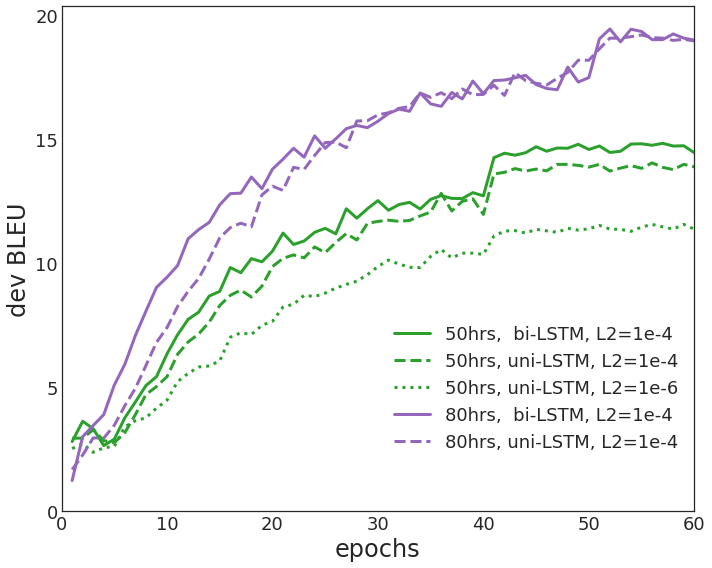

In [48]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,8)
ax1.set_xlabel('epochs', size=24)

# plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    

for i, k in enumerate(dev_data):
    ax1.plot(dev_data[k][0][:60], 
             dev_data[k][2][:60]*100, linewidth=3, 
             color=model_color[i], label=k, linestyle=model_line_style[i])
    ax1.set_ylabel('dev BLEU', size=24)
    print(dev_data[k][2][-1])
ax1.set_xlim(0, 60)
plt.yticks(list(range(0,25,5)), rotation=0, fontsize=20)
for tl in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    tl.set_fontsize(18) 
plt.legend(bbox_to_anchor=(.5, .4), framealpha=0, fontsize=18)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()
fig.savefig(fname="bleu_vs_birnn_l2.pdf", dpi=300)
fig.savefig(fname="bleu_vs_birnn_l2.png", dpi=300)

In [ ]:
nmt_models = ["sp2enw_hyp_search/sp_1.0_l2e-4_rnn-3_drpt-0.5_cnn_96-2-2/",
              "sp2enc_hyp_search/sp_1.0_l2e-6_rnn-3_drpt-0.5_cnn_64-2-2/"
             ]

model_keys = ["160hrs, speech to word",
              "160hrs, speech to char",
             ]

model_line_style = ["-", "--"]

model_color = [tableau20[4], tableau20[8]]


# log_train = np.loadtxt(os.path.join(cfg_path, "train.log"), delimiter=',', skiprows=False).transpose()
dev_data = {}
for k,p in zip(model_keys, nmt_models):
    m_path = os.path.join(p, "dev.log")
    dev_data[k] = np.genfromtxt(m_path, 
                                 delimiter=',', 
                                 usecols = (0,1,2)).transpose()

In [ ]:
40 * 90 / 60 / 24, 40 * 180 / 60 / 24

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.set_xlabel('epochs', size=24)

# plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    

for i, k in enumerate(dev_data):
    ax1.plot(dev_data[k][0][:40], 
             dev_data[k][2][:40]*100, linewidth=3, 
             color=model_color[i], label=k, linestyle=model_line_style[i])
    ax1.set_ylabel('dev bleu', size=24)
    print(dev_data[k][2][40])

ax1.set_xlim(0, 40)
ax1.set_ylim(0, 26)

plt.yticks(list(range(5,25,5))+[8, 23], rotation=0, fontsize=20)
ax1.axhline(y=23, linestyle=":", color="black", linewidth=2)
ax1.axhline(y=8, linestyle=":", color="black", linewidth=2)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

plt.text(34, 24, r'2.5 days', fontdict=font)
plt.text(35, 9, r'5 days', fontdict=font)

for tl in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    tl.set_fontsize(18) 
plt.legend(bbox_to_anchor=(.3, .4), framealpha=0, fontsize=18)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()
fig.savefig(fname="bleu_word_vs_char.pdf", dpi=300)
fig.savefig(fname="bleu_word_vs_char.png", dpi=300)

In [ ]:
# fig, ax = plt.subplots(figsize=(8,7),nrows=1, ncols=1, sharey=True)
# sns.set_style("white")

# # x_labels = ["{0:d} hrs".format(int(160 * (i/100))) for i in x_scale]

# markersize = 15
# linewidth = 2
# alpha = 1

# ax.plot(bar_x, bleu_short, label="short utts", color=tableau20[8], 
#         linewidth=linewidth, alpha=alpha,
#         marker='^', markersize=markersize)

# ax.plot(bar_x, bleu_medium, label="medium", color=tableau20[4], 
#         linewidth=linewidth, alpha=alpha, 
#         marker='o', markersize=markersize, linestyle="-")


# ax.plot(bar_x, bleu_long, label="long", color=tableau20[2], 
#         linewidth=linewidth, alpha=alpha, 
#         marker='s', markersize=markersize, linestyle="-")

# font = {'family': 'serif',
#         'color':  'black',
#         'weight': 'normal',
#         'size': 14,
#         }

# # ax.axhline(y=46.5, linestyle=":")
# # plt.text(40, 47, r'Google bleu - 160 hrs', fontdict=font)
# # ax.axhline(y=36.5, linestyle=":")
# # plt.text(40, 37, r'Google meteor- 160 hrs', fontdict=font)

# # ax.axhline(y=53, linestyle="-.")
# # plt.text(40, 53.5, r'Human bleu - 160 hrs', fontdict=font, alpha=0.5)
# # ax.axhline(y=40.5, linestyle="-.")
# # plt.text(40, 41, r'Human meteor - 160 hrs', fontdict=font, alpha=0.5)

# plt.xticks(bar_x, x_labels, rotation=45, fontsize=16)
# plt.yticks(list(range(5,25,5))+[27, 47, 53, 37, 41], rotation=0, fontsize=20)
# ax.set_xlabel('training data used', size=20)
# ax.set_ylabel('scores', size=20)
# for i in ax.get_xticklabels():
#     i.set_fontsize(16)
# for i in ax.get_yticklabels():
#     i.set_fontsize(16)

# plt.legend(bbox_to_anchor=(1.0, 0.26), framealpha=0, fontsize=20, ncol=1)
# plt.ylim(0,60)
# plt.xlim(0,102)
# ax.xaxis.grid(False)

# # sns.despine(left=True, bottom=True)

# fig.tight_layout()

# # fig.savefig(fname="bleu_meteor_scores.pdf", dpi=300)
# # fig.savefig(fname="bleu_meteor_scores.png", dpi=300)

In [ ]:
# fig, ax = plt.subplots(figsize=(8,7),nrows=1, ncols=1, sharey=True)
# sns.set_style("darkgrid")

# # word2word_x = [35, 52]
# # word2word_y = [47, 52]

# # google_char2char_x = [102]
# # google_char2char_y = [58.7]

# # x_labels = ["{0:d} hrs\n({1:d}%)".format(int(160 * (i/100)), int(i)) for i in x_scale]
# x_labels = ["{0:d} hrs".format(int(160 * (i/100))) for i in x_scale]

# bar_colors = [tableau20[0]]*6

# # ax.scatter(x=bar_x, y=bar_y, s=200, marker='o' , label="edin:speech-to-word", c=tableau20[8])

# # ax.bar(bar_x, bar_y, label="sp2word", color=tableau20[8], hatch="-", width=4, alpha=.8)
# ax.bar(bar_x, bar_y, label="sp2word", color=tableau20[8], hatch="-", width=4, alpha=.8)

# # word-to-word level
# # ax.scatter(x=word2word_x, y=word2word_y, s=200, marker='+' , label="edin:word-to-word", c=tableau20[8])

# # google
# # ax.scatter(x=[100], y=[47], s=200, marker='^' , label="google:speech-to-char", c=tableau20[4])
# # ax.scatter(x=google_char2char_x, y=google_char2char_y, s=200, marker='s' , label="google:char-to-char", c=tableau20[4])
# ax.bar([104], [47], label="google", color=tableau20[4], hatch='x', width=4, alpha=.8)

# # -------------------------------------------------------------
# # # old code
# # ax = sns.regplot(x=bar_x, y=bar_y, ax=ax, 
# #                  scatter_kws={"alpha":1.0, 's':200}, 
# #                  line_kws={"linestyle":"--"},
# #                  color=tableau20[8], fit_reg=False,
# #                 label="our models")
# # -------------------------------------------------------------

# # markerline, stemlines, baseline = ax.stem(bar_x, bar_y, linefmt='-', markerfmt=' ', basefmt=' ')
# # plt.setp(stemlines, 'color', tableau20[8], 'linewidth', 4)

# # markerline, stemlines, baseline = ax.stem(word2word_x, word2word_y, linefmt='--', markerfmt=' ', basefmt=' ')
# # plt.setp(stemlines, 'color', tableau20[8], 'linewidth', 4)

# # markerline, stemlines, baseline = ax.stem([100], [47], linefmt='-', markerfmt=' ', basefmt=' ')
# # plt.setp(stemlines, 'color', tableau20[4], 'linewidth', 4)

# # markerline, stemlines, baseline = ax.stem(google_char2char_x, google_char2char_y, linefmt='--', markerfmt=' ', basefmt=' ')
# # plt.setp(stemlines, 'color', tableau20[4], 'linewidth', 4)


# plt.xticks(bar_x, x_labels, rotation=45, fontsize=16)
# plt.yticks(list(range(5,30,5))+[47, 52, 58, 100], rotation=0, fontsize=20)
# ax.set_xlabel('training data used', size=20)
# ax.set_ylabel('BLEU scores', size=20)
# for i in ax.get_xticklabels():
#     i.set_fontsize(20)
# for i in ax.get_yticklabels():
#     i.set_fontsize(14)

# plt.legend(bbox_to_anchor=(.85, 0.96), framealpha=0, fontsize=20, ncol=1)
# plt.ylim(0,100)
# plt.xlim(0,110)
# ax.xaxis.grid(False)

# # sns.despine(left=True, bottom=True)

# fig.tight_layout()

# fig.savefig(fname="bleu_scores.pdf", dpi=300)

## Speech Translation - Precision and Recall

In [ ]:
metrics = {'google': {}}

In [ ]:
metrics['google'] = {}

google_p_vals = [np.array([58.26, 57.86, 57.98, 57.68]),
                 np.array([33.86, 33.62, 33.43, 33.12]),
                 np.array([20.85, 20.62, 20.48, 20.11]),
                 np.array([13.02, 12.75, 12.81, 12.43])]

metrics['google']['p'] = [np.mean(v) for v in google_p_vals]
metrics['google']['p_std'] = [np.std(v) / np.sqrt(len(v)) for v in google_p_vals]

google_r_vals = [np.array([57.36, 57.79, 57.68, 57.30]),
                 np.array([33.29, 33.56, 33.25, 32.89]),
                 np.array([20.48, 20.57, 20.36, 19.96]),
                 np.array([12.77, 12.71, 12.73, 12.34])]

metrics['google']['r'] = [np.mean(v) for v in google_r_vals]
metrics['google']['r_std'] = [np.std(v) / np.sqrt(len(v)) for v in google_r_vals]

In [ ]:
model_files = {"s2w-0.10": "./sp2enw/sp_.10/",
               "s2w-0.25": "./sp2enw/sp_.25/",
               "s2w-0.33": "./sp2enw/sp_.33/",
               "s2w-0.50": "./sp2enw/sp_.50/",
               "s2w-1.0" : "./sp2enw/sp_1.0_l2e-3",               
               }

In [ ]:
model_files.keys()

In [ ]:
for key, m_fil in model_files.items():
    with open(os.path.join(m_fil, "s2w_p_r.json"), "r") as out_f:
        metrics[key] = json.load(out_f)

In [ ]:
for k in metrics:
    print(metrics[k]['p'][0])

In [ ]:
fig, ax = plt.subplots(figsize=(8,5),nrows=1, ncols=1, sharey=True)
sns.set_style("darkgrid")

py_vals = [metrics[k]['p'][0] for k in metrics if k != "google"]
px_vals = x_scale-3
px_vals[-1] = 103
ax.bar(px_vals, py_vals, label="edin:precision", color=tableau20[8], hatch="", width=2, alpha=.8)

ry_vals = [metrics[k]['r'][0] for k in metrics if k != "google"]
rx_vals = x_scale-6
rx_vals[-1] = 97
ax.bar(rx_vals, ry_vals, label="edin:recall", color=tableau20[8], hatch="-", width=2, alpha=.5)


ax.bar([106], [metrics['google']['p'][0]], label="google:precision", color=tableau20[4], hatch='x', width=2, alpha=.8)
ax.bar([100], [metrics['google']['r'][0]], label="google:recall", color=tableau20[4], hatch='\\', width=2, alpha=.5)


plt.xticks(x_scale-4, x_labels, rotation=45)
plt.yticks([0,100]+list(range(20,40,10))+[42, 58], rotation=0, fontsize=18)

ax.set_xlabel('training data used', size=20)
ax.set_ylabel('translation metrics', size=20)
for i in ax.get_xticklabels()+ax.get_yticklabels():
    i.set_fontsize(18)

plt.yticks(fontsize=16, rotation=0)

plt.ylim(0,100)
plt.xlim(-10,120)
ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

plt.legend(bbox_to_anchor=(0.94, 0.96), framealpha=0, fontsize=18, ncol=2)

fig.tight_layout()
fig.savefig(fname="s2t_prec_rec.png", dpi=300)

## Speech Translation - Sample Translations

In [ ]:
sample_translations = {
    'reference' : """i ' m from puerto rico but i live here in denver colorado""",
    'google' : """i'm from puerto rico but i live here in denver colorado""",   
    "edin:160 hrs" : """i ' m from puerto rico but i live here in denver colorado""",
    'edin:80 hrs' : """i ' m from puerto rico but i live here in canada""",
    'edin:52 hrs' : """and i ' m from puerto rico but i live in the colorado""",
    'edin:40 hrs' : """and i ' m four five hours here in the same time here in canada""",
    'edin:16 hrs' : """and i was the united states i was in the united states""",
}

In [ ]:
print("{0:20s} | {1:<60s}".format("model", "translation"))
print("-"*80)
print("\n".join(["{0:20s} | {1:60s}".format(k, v) for k, v in sample_translations.items()]))

## English word spotting

In [ ]:
from IPython.display import Image

### Selected topics and their counts in the dev set

Number of topics = 28

total number of utterances in which topic words occur = 217
total utterances in dev set = 3977

To spot a keyword, we **stem** it, and then count the utterances in which the keyword occurs (using the translations).

**Note**: For this task, **we predict whether an utterance contains a keyword or not**. If there are multiple instances of the keyword in an utterance, only one will be counted


total tokens in dev set = 170,346

In [ ]:
Image("../criseslex/sel_topics.png")

In [ ]:
Image("../criseslex/sel_topics_new.png")

### Precision and Recall

In [ ]:
topics_metrics = {}

topics_metrics['google'] = {'p' : 75, 'r' : 69}

In [ ]:
for key, m_fil in model_files.items():
    with open(os.path.join(m_fil, "topics_p_r.json"), "r") as out_f:
        temp = json.load(out_f)
        topics_metrics[key] = {'p':temp['precision']*100, 'r':temp['recall']*100}

In [ ]:
topics_metrics

In [ ]:
fig, ax = plt.subplots(figsize=(8,5),nrows=1, ncols=1, sharey=True)
sns.set_style("darkgrid")

py_vals = [topics_metrics[k]['p'] for k in topics_metrics if k != "google"]
px_vals = x_scale-3
px_vals[-1] = 103
ax.bar(px_vals, py_vals, label="edin:precision", color=tableau20[8], hatch="", width=2, alpha=.8)

ry_vals = [topics_metrics[k]['r'] for k in topics_metrics if k != "google"]
rx_vals = x_scale-6
rx_vals[-1] = 97
ax.bar(rx_vals, ry_vals, label="edin:recall", color=tableau20[8], hatch="-", width=2, alpha=.5)


ax.bar([106], [topics_metrics['google']['p']], label="google:precision", color=tableau20[4], hatch='x', width=2, alpha=.8)
ax.bar([100], [topics_metrics['google']['r']], label="google:recall", color=tableau20[4], hatch='\\', width=2, alpha=.5)


plt.xticks(x_scale-4, x_labels, rotation=45)
plt.yticks([0,100]+list(range(20,40,10))+[40, 75], rotation=0, fontsize=20)

ax.set_xlabel('training data used', size=20)
ax.set_ylabel('word spotting metrics', size=20)
for i in ax.get_xticklabels()+ax.get_yticklabels():
    i.set_fontsize(18)

plt.yticks(fontsize=18, rotation=0)

plt.ylim(0,100)
plt.xlim(-10,120)
ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

plt.legend(bbox_to_anchor=(0.9, 1.01), framealpha=0, fontsize=18, ncol=2)

fig.tight_layout()
fig.savefig(fname="word_spotting_prec_rec.png", dpi=300)

In [ ]:
model_files

In [ ]:
m_fil = './sp2enw/sp_.50'

In [ ]:
with open(os.path.join(m_fil, "topics_p_r.json"), "r") as out_f:
    all_topic_metrics = json.load(out_f)

In [ ]:
sorted_topic_metrics = sorted(all_topic_metrics['terms'].items(), reverse=True, key=lambda t:t[1]['t'])

In [ ]:
terms = [i[0] for i in sorted_topic_metrics]

In [ ]:
t_vals = [all_topic_metrics['terms'][i]['t'] for i in terms]
tp_vals = [all_topic_metrics['terms'][i]['tp'] for i in terms]
tc_vals = [all_topic_metrics['terms'][i]['tc'] for i in terms]

In [ ]:
len(terms)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1, sharey=True)
sns.set_style("white")

sns.barplot(x=t_vals, y=terms, **{"alpha": .5, "color":tableau20[0]})
sns.barplot(x=tc_vals, y=terms, **{"alpha": .9, "color":tableau20[4]})

In [ ]:
len(terms)